In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math 
import astropy
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.colors as colors


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
#SciServer Modules
import SciServer
from SciServer import CasJobs

In [3]:
#Query of fluxes for different emission lines
EmLFQry= """select drp.MaNGAid, drp.objRA, drp.objDEC, drp.z, 
drp.nsa_elpetro_absmag_r as rMAG, 
drp.nsa_elpetro_absmag_g as gMAG, 
drp.nsa_elpetro_mass as GalMass, 

dap.emline_sflux_cen_oiii_5008 as OIII,  
dap.emline_sflux_cen_hb_4862 as HB, 
dap.emline_sflux_cen_nii_6585 as NII, 
emline_sflux_cen_ha_6564 as Ha, 

dap.daptype
from mangaDRPall as drp
JOIN mangaDAPall as dap on dap.mangaid = drp.mangaid
WHERE (drp.z < 0.15) and (drp.z > 0.001) 
and dap.daptype = 'HYB10-MILESHC-MASTARHC2'
and (5e9 > drp.nsa_elpetro_mass)
"""
           
Selection1 = CasJobs.executeQuery(EmLFQry, 'dr17')
print(Selection1)

GalMass = []
for i in range(len(Selection1['GalMass'])):
    GalMass.append([Selection1['GalMass'][i]])

       MaNGAid       objRA     objDEC         z     rMAG     gMAG  \
0      1-48188  133.685670  57.480250  0.040811 -19.0722 -18.5151   
1     1-153412  123.061819  35.157138  0.017492 -18.5115 -18.0485   
2     1-384222  125.062375  21.060055  0.016621 -16.5588 -15.8600   
3     1-384250  124.908696  21.285361  0.015160 -18.2709 -17.5609   
4     1-384306  125.110457  22.384363  0.026109 -17.8002 -17.2181   
...        ...         ...        ...       ...      ...      ...   
3412  1-623710  195.182800  28.416320  0.021025 -17.1722 -16.6895   
3413  1-456694  194.792937  27.619843  0.019146 -18.5917 -17.8751   
3414  1-456969  195.363110  27.999188  0.025495 -18.8189 -18.0698   
3415  1-457149  195.839822  28.309053  0.018426 -18.1577 -17.4755   
3416  1-457238  196.671361  27.884139  0.023517 -17.9665 -17.3060   

           GalMass        OIII          HB        NII          Ha  \
0     4.642460e+09    5.077570    8.332563   9.845490   19.466420   
1     2.332640e+09  165.164100  1

In [4]:
print('Max Mass Index: ' + str(GalMass.index(max(GalMass))))
print('Min Mass Index: ' + str(GalMass.index(min(GalMass))))

Max Mass Index: 1324
Min Mass Index: 46


In [13]:
#Max Massive Mass
i = 1324

print('Most Massive Galaxy: \n')
print('ID: ' + str(Selection1['MaNGAid'][i]))
print('Mass: ' + str(Selection1['GalMass'][i]))
print('z: ' + str(Selection1['z'][i]))
print('OIII: ' + str(Selection1['OIII'][i]))
print('HB: ' + str(Selection1['HB'][i]))
print('NII: ' + str(Selection1['NII'][i]))
print('Ha: ' + str(Selection1['Ha'][i]) + '\n')
print('\n')

#Mass Massive Mass
i = 46

print('Least Massive Galaxy: \n')
print('ID: ' + str(Selection1['MaNGAid'][i]))
print('Mass: ' + str(Selection1['GalMass'][i]))
print('z: ' + str(Selection1['z'][i]))
print('OIII: ' + str(Selection1['OIII'][i]))
print('HB: ' + str(Selection1['HB'][i]))
print('NII: ' + str(Selection1['NII'][i]))
print('Ha: ' + str(Selection1['Ha'][i]))

Most Massive Galaxy: 

ID: 1-76417
Mass: 4999580000.0
z: 0.0286812
OIII: 15.86546
HB: 31.6316
NII: 49.7499
Ha: 136.3662



Least Massive Galaxy: 

ID: 58-58
Mass: -9999.0
z: 0.07
OIII: 0.02478845
HB: 3.472559
NII: -3.698751
Ha: -2.858208


In [14]:
 #Omitting NaN values from the raw data
BPTX = abs(Selection1['NII']/Selection1['Ha'])
BPTY = abs(Selection1['OIII']/Selection1['HB'])
ID = Selection1['MaNGAid']

BPTX = BPTX.dropna()
BPTY = BPTY.dropna()

BPTX = list(filter(None, BPTX))
BPTY = list(filter(None, BPTY))

print (len(BPTX))
print (len(BPTY))

3414
3414


In [15]:
#Separating the data based on the equations provided by Kauffman and Trou
agnBPTx = []
agnBPTy = []

sfBPTx = []
sfBPTy = []

gBPTx = []
gBPTy = []

#MaNGA ID Lists
AGN_ID = []

SF_ID = []

MaNGAID = Selection1['MaNGAid']

for i in range(len(BPTX)):
    if (BPTY[i] > ((-0.61 * (np.log(BPTX[i]) - 0.05)) + 1.3)) and (BPTY[i] > ((-1.2 * np.log(BPTX[i])) - 0.4)):
        agnBPTx.append(BPTX[i])
        agnBPTy.append(BPTY[i])
        AGN_ID.append(ID[i])
    elif (BPTY[i] < (-1.2 * np.log(BPTX[i])) - 0.4) and (BPTY[i] < ((-0.61 * (np.log(BPTX[i]) - 0.05)) + 1.3)):
        sfBPTx.append(BPTX[i])
        sfBPTy.append(BPTY[i])
        SF_ID.append(ID[i])
    elif (((BPTY[i] > (-1.2 * np.log(BPTX[i])) - 0.4) and (BPTY[i] < (-0.61 * (np.log(BPTX[i]) - 0.05) + 1.3 ))) or ((BPTY[i] < ((-0.61 * (np.log(BPTX[i]) - 0.05)) + 1.3)) and (BPTY[i] > (-1.2 * np.log(BPTX[i])) - 0.4))):
        gBPTx.append(BPTX[i])
        gBPTy.append(BPTY[i])
    else:
        print(str(BPTX[i]) + ', ' + str(BPTY[i]) + ': Index = ' + str(i))
        print('Something is broken :( \n')

        
print('Current Index: ' + str(i))
print(str(MaNGAID[i]) + '\n')

print('AGN Galaxies: ' + str(len(agnBPTx)))
print('Star Forming Galaxies: ' + str(len(sfBPTx)))
print('Grey Galaxies: ' + str(len(gBPTx)) + '\n')

print('AGN x: ' + str(agnBPTx))
print('AGN y: ' + str(agnBPTy) + '\n')

print('Star Forming x:' + str(sfBPTx))
print('Star Forming y:' + str(sfBPTy) + '\n')

print('Grey Galaxies x:' + str(gBPTx))
print('Grey Galaxies y:' + str(gBPTy) + '\n') 


Current Index: 3413
1-456694

AGN Galaxies: 531
Star Forming Galaxies: 2372
Grey Galaxies: 511

AGN x: [1.0224315212886395, 0.6041286449389709, 0.8157882958865942, 1.1118701172327736, 0.39220524777618426, 0.6329321960575592, 0.7565340518544995, 0.4416708425256463, 0.11117385382002518, 0.49416432842083174, 7.210195722856863, 1.1711979711191522, 2.6424663215145348, 0.4198566107708418, 1.4298906547498886, 2.0739432967160254, 3.702586693709329, 3.1845991475348634, 0.8393589904986405, 0.32233962936452726, 0.19264524185941465, 0.3984086401326456, 0.6245300810352604, 2.3565463473691817, 0.5872885838575298, 39.68254052593387, 2.229308137794708, 2.229308137794708, 1.0084550847544957, 1.5653834545922802, 4.37932280838309, 0.11499442541689057, 1.2647008748060546, 1.8245466337399288, 0.22281508909486264, 0.8262857980764492, 0.4567860748785172, 0.557632533819075, 10.989225627900021, 0.07675839512466656, 1.3617913874813352, 5.499039398079649, 2.125499374350542, 4.121709526183932, 3.261361990670014, 

In [22]:
#Creating Excel file for MaNGA IDs
from openpyxl import Workbook
import xlsxwriter

#AGN IDs
AGNExcel = pd.DataFrame({"MaNGA IDs: AGN": AGN_ID})
AGNExcel.to_excel("Dwarf_AGN_ID.xlsx", index=False)

#Star Forming IDs
SFExcel = pd.DataFrame({"MaNGA IDs: Star Forming": SF_ID})
SFExcel.to_excel("Dwarf_SF_ID.xlsx", index=False)

In [17]:
#Equations separating star forming and AGN populations
#Kaufmann et al. 2003
AGN = (-0.61 * (np.log(BPTX) - 0.05)) + 1.3
#Trouille et al. 2011
SF = (-1.2 * np.log(BPTX)) - 0.4

In [18]:
#Correcting order for pop separated lines
AGN_Line = np.array(list(zip(BPTX, AGN)))
AGN_Line = sorted(AGN_Line, key=lambda x: x[0])

SF_Line = np.array(list(zip(BPTX, SF)))
SF_Line = sorted(SF_Line, key=lambda x: x[0])

In [19]:
#Splitting elements back into two lists
BPTX_plt = []
AGN_plt = []
SF_plt = []

for i in range(len(AGN_Line)):
    BPTX_plt.append([AGN_Line[i][0]])
    AGN_plt.append([AGN_Line[i][1]])

for i in range(len(SF_Line)):
    SF_plt.append([SF_Line[i][1]])

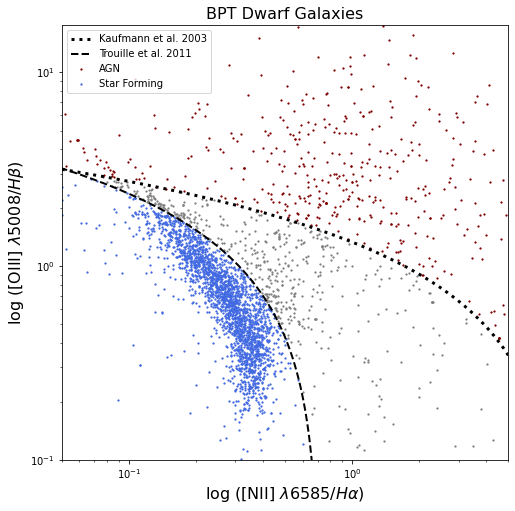

In [21]:
plt.figure(figsize = (8, 8))
plt.title('BPT Dwarf Galaxies', fontsize = 16)

#AGN
plt.scatter(agnBPTx, agnBPTy, color = 'maroon', alpha = 1, s = 1.5, label = "AGN")
#SF
plt.scatter(sfBPTx, sfBPTy, color = 'royalblue', alpha = 1, s = 1.5, label = "Star Forming")
#Grey
plt.scatter(gBPTx, gBPTy, color = 'grey', alpha = 1, s = 1.5)


plt.ylabel('log ([OIII] ${\u03BB}$5008/$H{\u03B2}$)', fontsize = 16)
plt.xlabel('log ([NII] ${\u03BB}$6585/$H{\u03B1}$)', fontsize = 16)
plt.xscale('log')
plt.yscale('log')
plt.xlim(.5e-1, 0.5e1)
plt.ylim(1e-1, 1.75e1)

plt.plot(BPTX_plt, AGN_plt, color = 'black', linestyle = ':', linewidth = 3, label = "Kaufmann et al. 2003")
plt.plot(BPTX_plt, SF_plt, color = 'black', linestyle = '--', linewidth = 2, label = "Trouille et al. 2011")
legend = plt.legend(loc = 'upper left')

plt.savefig('Dwarf Galaxy BPT Diagram', dpi = 600, bbox_inches = 'tight')
plt.show()